In [1]:
%load_ext watermark
%watermark -a "Teresiah Kahura" -d -t -v -p numpy,pandas,matplotlib -g

Teresiah Kahura 2020-08-08 14:01:01 

CPython 3.7.3
IPython 7.16.1

numpy 1.18.5
pandas 0.24.2
matplotlib 3.0.3
Git hash: 26f5332e6506f83cc12a9d8f7aadc88994e7ef23


In [2]:
from __future__ import print_function
%matplotlib inline

import datetime

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [3]:
path = '/Users/teresiahkahura/Desktop/ds/SB-Capstone2/data/processed/reviews2.pkl'
df = pd.read_pickle(path)

assert df.shape == (3268, 2)

# Preprocessing

In [4]:
x = df["text"]
y = df["label"].values

In [5]:
tokenizer = Tokenizer(lower=True, filters='\d*!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split = ' ')
tokenizer.fit_on_texts(x)

In [6]:
def get_sequence_of_tokens(corpus):
    
    
    total_words = len(tokenizer.word_index) + 1
    
     
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(x)

In [7]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.30, random_state=42)

# Setting up LSTM

In [9]:
def build_model():
  opt = Adam(lr=0.01)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(total_words, 128))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.7, recurrent_dropout=0.7, return_sequences=True)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
  model.add(tf.keras.layers.Dense(6, kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

lstm_model = build_model()

In [10]:
!rm -r /tmp/logs/

In [11]:
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only= True)

Fitting the model takes approximately 5 minutes.

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_lstm = lstm_model.fit(x_train, y_train, epochs = 5, validation_split = 0.1, 
                              callbacks = [tb_callback, checkpoint])

Epoch 1/5
 1/65 [..............................] - ETA: 0s - loss: 1.5837 - accuracy: 0.5625WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
65/65 [==============================] - ETA: 0s - loss: 0.8437 - accuracy: 0.5029
Epoch 00001: val_loss improved from inf to 0.71548, saving model to /tmp/sentiment_analysis.hdf5
65/65 [==============================] - 77s 1s/step - loss: 0.8437 - accuracy: 0.5029 - val_loss: 0.7155 - val_accuracy: 0.4978
Epoch 2/5
65/65 [==============================] - ETA: 0s - loss: 0.7003 - accuracy: 0.5957
Epoch 00002: val_loss did not improve from 0.71548
65/65 [==============================] - 80s 1s/step - loss: 0.7003 - accuracy: 0.5957 - val_loss: 0.7228 - val_accuracy: 0.5546
Epoch 3/5

In [15]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])
  plt.show()

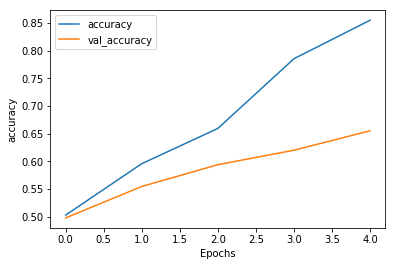

In [16]:
plot_graphs(history_lstm, 'accuracy')

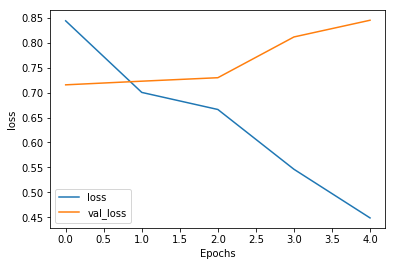

In [17]:
plot_graphs(history_lstm, 'loss')

In [14]:
results = lstm_model.evaluate(x_test, y_test)
print(results)

31/31 [==============================] - 5s 150ms/step - loss: 0.9006 - accuracy: 0.6351
[0.9006018042564392, 0.6350662708282471]


The best performing and fastest classifier so far is the Bernoulli Naive Bayes, followed by the LSTM neural network and in last position is the simple RNN. The LSTM is the slowest at classifying so might not be feasible with scant memory resources.